In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 绘制TDA和BOF对Acc的相关性

## 首先需要定义一些函数

### 计算相关性的函数

In [185]:
# 这里需要定义一个计算相关性的函数
# 计算的是*spearman correlation*

from scipy.stats import spearmanr

def calculate_spearman_correlation(vector1, vector2):
    """
    Calculate the Spearman correlation between two vectors.

    Parameters:
    - vector1 (array-like): The first vector.
    - vector2 (array-like): The second vector.

    Returns:
    - float: The Spearman correlation coefficient.
    - float: The two-tailed p-value for a hypothesis test whose null hypothesis is that the two samples are uncorrelated.
    """
    correlation_coefficient, p_value = spearmanr(vector1, vector2)
    return correlation_coefficient, p_value

# Example Usage:
vector1 = [1, 2, 3, 4, 5]
vector2 = [2, 3, 1, 4, 5]

correlation, p_value = calculate_spearman_correlation(vector1, vector2)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")


Spearman Correlation Coefficient: 0.7
P-value: 0.1881204043741873


### 计算数据中的相关性

In [204]:
import pandas as pd
def calculate_correlation_between_excel_sheets(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x:int =100):
    """
    Calculate the Spearman correlation between the first x% of data in two columns in different Excel files.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - sheet_name1 (str): Name of the sheet in the first Excel file.
    - column_name1 (str): Name of the column in the first sheet for which correlation is calculated.

    - file_path2 (str): Path to the second Excel file.
    - sheet_name2 (str): Name of the sheet in the second Excel file.
    - column_name2 (str): Name of the column in the second sheet for which correlation is calculated.

    - x (float): The percentage of data to consider for correlation calculation.

    Returns:
    - float: The Spearman correlation coefficient.
    - float: The two-tailed p-value for a hypothesis test whose null hypothesis is that the two samples are uncorrelated.
    """
    # Read data from Excel files
    df1 = pd.read_excel(file_path1, sheet_name=sheet_name1)
    df2 = pd.read_excel(file_path2, sheet_name=sheet_name2)
    # print(df1)
    # print(df2)

    # Calculate the number of rows to select
    num_rows = int(len(df1) * x / 100)

    # Select the first x% of data
    vector1 = df1[column_name1].head(num_rows)
    vector2 = df2[column_name2].head(num_rows)

    # Calculate Spearman correlation
    correlation_coefficient, p_value = calculate_spearman_correlation(vector1, vector2)

    return correlation_coefficient, p_value


# Example Usage:
file_path1 = './input_data/best_val_acc.xlsx'
sheet_name1 = 'Angle'
column_name1 = 'ResNet152'

file_path2 = './input_data/TDA_data.xlsx'
sheet_name2 = sheet_name1
column_name2 = ['Data']

correlation, p_value = calculate_correlation_between_excel_sheets(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x=100)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman Correlation Coefficient: 0.008535461097340626
P-value: 0.9094601540489842


In [187]:
import pandas as pd
import re

# 自定义排序函数
def sort_by_number(column_name):
    # 从列名中提取数字
    numbers = re.findall(r'\d+', column_name)
    if numbers:
        return int(numbers[0])
    else:
        return 0

# # 将列名按照数字大小排序
# df_pivot_sorted = df_pivot.sort_values(by=lambda x: sort_by_number(x), axis=1)

# # 保存到Excel
# df_pivot_sorted.to_excel(excel_path)


def calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names1, column_names2, if_data=False, excel_path = 'output_file.xlsx', percentage:int =50):
    """
    Calculate Spearman correlations for all combinations of sheets and columns between two Excel files.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - file_path2 (str): Path to the second Excel file.
    - sheet_names (list): List of sheet names present in both Excel files.
    - column_names (list): List of column names present in each sheet.

    Returns:
    - pd.DataFrame: DataFrame containing correlation coefficients for all combinations.
    """
    correlation_data = []

    for sheet_name in sheet_names:
        for column_name1, column_name2 in zip(column_names1, column_names2):
            
            correlation_coefficient, p_value = calculate_correlation_between_excel_sheets(
                    file_path1, sheet_name, column_name1,
                    file_path2, sheet_name, column_name2,
                    x = percentage
                )
            
            correlation_data.append({
                'Sheet': sheet_name,
                'Column': column_name1,
                'Correlation': correlation_coefficient,
                'P-value': p_value
            })

    correlation_df = pd.DataFrame(correlation_data)
    
    # Sample DataFrame
    data = correlation_df

    df = pd.DataFrame(data)

    # Drop the 'P-value' column
    df = df.drop('P-value', axis=1)

    # Pivot the DataFrame
    df_pivot = df.pivot(index='Sheet', columns='Column', values='Correlation')
    # Set 'Sheet' as the index
    # df_pivot.set_index('Column', inplace=True)

    # Save to Excel
    
    df_pivot.to_excel(excel_path)

    print(f'DataFrame saved to {excel_path}')
    return df_pivot



### 绘制柱形图

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.backends.backend_pdf as pdf_backend

def plot_grouped_bar_chart(file_path1, file_path2, row_index, aug_names = ['Angle', 'Scale'],columns_order=['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152'],label1='Data TDA v.s. Acc',label2='Model output v.s. Acc', title_key='TDA'):
    """
    Read specified rows from two Excel files and plot a grouped bar chart.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - file_path2 (str): Path to the second Excel file.
    - row_index (int): Index of the row to plot.

    Returns:
    - None
    """
    
    # Read data from Excel files
    df1 = pd.read_excel(file_path1, index_col=0)
    df2 = pd.read_excel(file_path2, index_col=0)
    # 调整列的顺序
    df1 = df1[columns_order]
    df2 = df2[columns_order]

    # Select the specified row
    row_data1 = df1.iloc[row_index]
    row_data2 = df2.iloc[row_index]
    # print(row_data1, '\n', row_data2)

    # Organize data for plotting
    columns = df1.columns
    positions = np.arange(len(columns))
    bar_width = 0.1

    # Plotting
    fig, ax = plt.subplots()
    bars1 = ax.bar(positions - bar_width/2, row_data1, bar_width, label=label1)
    bars2 = ax.bar(positions + bar_width/2, row_data2, bar_width, label=label2)

    # Set labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel('Spearman orrelation')
    ax.set_title(f'Spearman orrelation between Acc and {title_key} in {aug_names[row_index]}')
    ax.set_xticks(positions)
    ax.set_xticklabels(columns)
    ax.legend()

    # Save the plot as PDF
    pdf = pdf_backend.PdfPages(f"Spearman orrelation between Acc and {title_key} in {aug_names[row_index]}.pdf")
    pdf.savefig(fig)
    pdf.close()

    # Show the plot
    plt.show()


## 计算TDA v.s. Acc相关性和画图

In [206]:
# Example Usage:
file_path1 = './input_data/best_val_acc.xlsx'
file_path2 = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'
file_path_data = './input_data/TDA_data.xlsx'
sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
percenatge = 50
model_excel_path=f'./output_correlation/TDA_output_correlation_{percenatge}.xlsx'
data_excel_path=f'./output_correlation/TDA_data_correlation_{percenatge}.xlsx'
TDA_correlation_df = calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names,column_names, excel_path=model_excel_path, percentage=percenatge)
TDA_correlation_df_data = calculate_correlations_for_all_columns(file_path1, file_path_data, sheet_names, column_names,['Data']*7, if_data=True, excel_path=data_excel_path, percentage=percenatge)
# Display the resulting DataFrame
print(TDA_correlation_df)
print(TDA_correlation_df_data)

DataFrame saved to ./output_correlation/TDA_output_correlation_50.xlsx
DataFrame saved to ./output_correlation/TDA_data_correlation_50.xlsx
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle   0.333329  0.380527   0.110650  -0.132465  0.137789  0.080418  0.105935
Scale  -0.501236 -0.457129  -0.010872  -0.056832  0.189723 -0.053880 -0.200198
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle   0.397718  0.468937   0.093023  -0.151779  0.189819  0.117161  0.134636
Scale   0.260999 -0.051396   0.358290   0.299975  0.402174 -0.183391  0.366782


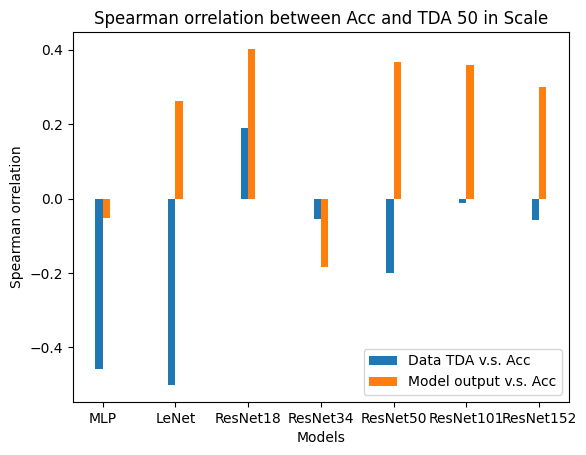

In [208]:
# Example Usage:
TDA_file_path1 = model_excel_path
TDA_file_path2 = data_excel_path
row_index = 1  # Choose the row index to plot

plot_grouped_bar_chart(TDA_file_path1, TDA_file_path2, row_index, title_key=f'TDA {percenatge}')


## 计算BOF v.s. Acc 的相关性和画图

In [218]:
# Example Usage:
BOF_file_path1 = './input_data/best_val_acc.xlsx'
# file_path2 = './input_data/BOF_data.xlsx'
BOF_file_path_data = './input_data/BOF_data.xlsx'
sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
percenatge = 100
chose = 'rk_max'
excel_path=f'./output_correlation/{chose}_BOF_data_correlation_{percenatge}.xlsx'
# correlation_df = calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names,column_names, excel_path='./output_correlation/TDA_output_correlation.xlsx')
correlation_df_data = calculate_correlations_for_all_columns(BOF_file_path1, BOF_file_path_data, sheet_names, column_names,[f'{chose}']*7, if_data=True, excel_path=excel_path, percentage=percenatge)
# Display the resulting DataFrame
# print(correlation_df)
print(correlation_df_data)

DataFrame saved to ./output_correlation/rk_max_BOF_data_correlation_100.xlsx
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle  -0.408181 -0.425066  -0.242014  -0.059754 -0.314307 -0.299163 -0.247753
Scale  -0.868324 -0.928305  -0.863178  -0.886059 -0.821277 -0.941224 -0.831997


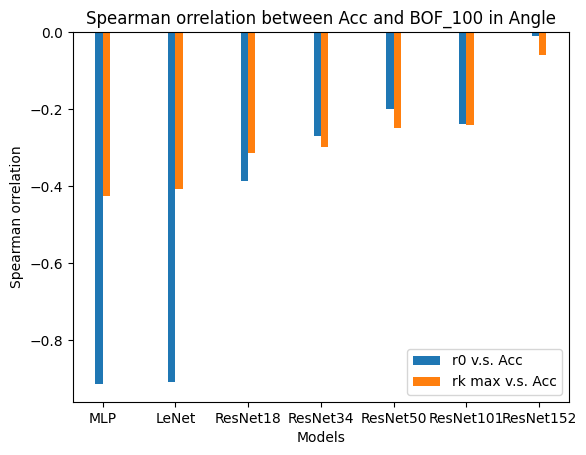

In [221]:
# Example Usage:
file_path1 = f'./output_correlation/r0_BOF_data_correlation_{percenatge}.xlsx'
file_path2 = f'./output_correlation/rk_max_BOF_data_correlation_{percenatge}.xlsx'
row_index = 0  # Choose the row index to plot

plot_grouped_bar_chart(file_path1, file_path2, row_index, label1='r0 v.s. Acc', label2='rk max v.s. Acc', title_key=f'BOF_{percenatge}')


# 绘制输入中的数据

我发现计算得到的相关度和预计的有一些差距，为了研究这个问题，我决定探究一下输入数据的情况。

## 首先定义一些函数用来画图

### 一个读取excle的函数

In [176]:
import pandas as pd

def read_excel(file_path):
    # 读取Excel文件
    xls = pd.ExcelFile(file_path)

    # 获取所有Sheet的名称
    sheet_names = xls.sheet_names

    # 用于存储每个Sheet的DataFrame
    dataframes = []

    # 遍历每个Sheet，读取数据并转换为DataFrame
    for sheet_name in sheet_names:
        df = xls.parse(sheet_name)
        dataframes.append(df)

    return dataframes

file_path = "./input_data/best_val_acc.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

Sheet 1:
    Index   LeNet     MLP  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
0       0  0.6314  0.5229    0.8807    0.9164    0.8870     0.8948     0.8946
1       1  0.6725  0.5775    0.8914    0.9198    0.9025     0.9073     0.9070
2       2  0.6970  0.5867    0.9023    0.8934    0.9074     0.9141     0.9149
3       3  0.6836  0.5939    0.9042    0.9300    0.9152     0.9176     0.9181
4       4  0.7065  0.5860    0.9099    0.9306    0.9192     0.9206     0.9201
5       5  0.7161  0.5926    0.9156    0.9355    0.9231     0.9236     0.9250
6       6  0.7228  0.5963    0.9184    0.9372    0.9213     0.9257     0.9243
7       7  0.7260  0.5972    0.9238    0.9357    0.9317     0.9269     0.9348
8       8  0.7220  0.6067    0.9277    0.9384    0.9273     0.9316     0.9269
9       9  0.7312  0.5989    0.9282    0.9377    0.9340     0.9371     0.9353
10     10  0.7190  0.5991    0.9315    0.9353    0.9287     0.9390     0.9405
11     11  0.7246  0.5975    0.9312    0.9383    0.9287

### 绘制函数图像

In [177]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_line_graphs(df, output_folder, xlabel: str= 'Enhanced strength', ylabel:str = 'Performance of the model', fig_title:str = 'Optimal performance of the model under', save_name:str = 'Scale'):
    # 创建输出文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)

    # 获取DataFrame的列名
    columns = df.columns

    # 遍历每一列，绘制折线图并保存为PDF
    for column in columns:
        # 创建一个新的图形
        plt.figure()

        # 归一化横坐标
        x = range(len(df))
        x_normalized = [(val - min(x)) / (max(x) - min(x)) for val in x]

        # 设置线和标记的样式
        plt.plot(x_normalized, df[column], linewidth=2, color='blue', marker='o', markersize=3, markerfacecolor='red')


        # 添加标题和轴标签
        plt.title(fig_title +" " + save_name)
        plt.xlabel(xlabel=xlabel)
        plt.ylabel(ylabel=ylabel)

        # 保存为PDF文件
        output_path = os.path.join(output_folder, column + save_name + '.pdf')
        plt.savefig(output_path)

        # 关闭图形
        plt.close()

import pandas as pd

# 创建一个示例DataFrame
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/Acc/"
plot_line_graphs(df, output_folder)

## 绘制图像

### 绘制Acc

In [181]:
# 加载数据到df
file_path = "./input_data/best_val_acc.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/Acc"
plot_line_graphs(df, output_folder, save_name='Scale')

Sheet 1:
    Index   LeNet     MLP  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
0       0  0.6314  0.5229    0.8807    0.9164    0.8870     0.8948     0.8946
1       1  0.6725  0.5775    0.8914    0.9198    0.9025     0.9073     0.9070
2       2  0.6970  0.5867    0.9023    0.8934    0.9074     0.9141     0.9149
3       3  0.6836  0.5939    0.9042    0.9300    0.9152     0.9176     0.9181
4       4  0.7065  0.5860    0.9099    0.9306    0.9192     0.9206     0.9201
5       5  0.7161  0.5926    0.9156    0.9355    0.9231     0.9236     0.9250
6       6  0.7228  0.5963    0.9184    0.9372    0.9213     0.9257     0.9243
7       7  0.7260  0.5972    0.9238    0.9357    0.9317     0.9269     0.9348
8       8  0.7220  0.6067    0.9277    0.9384    0.9273     0.9316     0.9269
9       9  0.7312  0.5989    0.9282    0.9377    0.9340     0.9371     0.9353
10     10  0.7190  0.5991    0.9315    0.9353    0.9287     0.9390     0.9405
11     11  0.7246  0.5975    0.9312    0.9383    0.9287

### 绘制BOF

In [182]:
# 绘制Data BOF
# 加载数据到df
file_path = "./input_data/BOF_data.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[1]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/BOF"
plot_line_graphs(df, output_folder, save_name='Angle', ylabel='BOF', fig_title='BOF of Data')

Sheet 1:
    Index        r0        R0  rk_max_index      rk_max       Rk_max
0       0  3.436844  9.225692    933.000000  341.117767   672.763733
1       1  3.413863  9.056010    934.599976  334.460754   661.249878
2       2  3.412494  9.002722    999.799988  327.374146   647.545837
3       3  3.426091  9.025197    980.700012  322.459290   638.184448
4       4  3.449736  9.092059   1339.900024  319.594452   628.856140
5       5  3.471112  9.155492   1747.599976  319.005188   621.564087
6       6  3.496571  9.233131   1783.900024  319.837219   621.670898
7       7  3.521122  9.310081   1786.500000  322.247742   624.957520
8       8  3.543707  9.378830   1804.099976  322.909851   626.623657
9       9  3.566939  9.448359   1788.500000  325.439392   631.996704
10     10  3.591511  9.523071   1816.599976  327.901184   632.762146
11     11  3.610572  9.579646   1834.500000  330.086853   635.375305
12     12  3.628019  9.616961   1879.099976  333.850006   636.865967
13     13  3.645803  9.64

### 绘制TDA

In [183]:
# 绘制Data TDA
# 加载数据到df
file_path = "./input_data/TDA_data.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/TDA"
plot_line_graphs(df, output_folder, save_name='Scale', ylabel='TDA', fig_title='TDA of Data')

# 绘制model TDA
file_path = "./input_data/TDA_out_2_all_bars_surviver_time.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/TDA"
plot_line_graphs(df, output_folder, save_name='Sacle', ylabel='TDA', fig_title='TDA of Model')


Sheet 1:
    Index        Data
0       0  692.552284
1       1  687.346969
2       2  688.396944
3       3  687.657427
4       4  691.318258
5       5  696.467763
6       6  688.518457
7       7  696.477020
8       8  692.843704
9       9  702.311659
10     10  702.346823
11     11  695.016732
12     12  695.719293
13     13  701.916926
14     14  703.176895
15     15  700.250126
16     16  701.874007
17     17  705.502274
18     18  704.909208
19     19  701.585905
20     20  708.894286
21     21  704.751849
22     22  703.437700
23     23  695.001254
24     24  703.134517
25     25  697.968605
26     26  692.363449
27     27  694.228293
28     28  691.691386
29     29  686.135951
30     30  684.079643
31     31  681.499469
32     32  674.154918
33     33  677.947637
34     34  670.924781
35     35  653.665044
36     36  656.900672
37     37  648.039264
38     38  631.638360
39     39  624.044938
40     40  621.189725
41     41  609.283009
42     42  584.333142
43     43  582.201653
4